In [1]:
import os, sys, warnings

import numpy as np # linear algebra
import pandas as pd # data processing

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
    
# Libraries and packages for NLP
import nltk, re
from nltk.stem.porter import PorterStemmer
import gensim
from gensim.models import Word2Vec

# Visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv('../input/imdb-reviews-iiit-project/movie_data.csv')
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [3]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

## 1. Data Preprocessing

In [4]:
class Tokenizer: 
    """ After cleaning and denoising steps, in this class the text is broken up into tokens.
    if clean: clean the text from all non-alphanumeric characters,
    if lower: convert the text into lowercase,
    If de_noise: remove HTML and URL components,
    If keep_neagation: attach the negation tokens to the next token 
     and treat them as a single word before removing the stopwords
     
    Returns:
    List of tokens
    """
    # initialization method to create the default instance constructor for the class
    def __init__(self,
                 clean: bool = True,
                 lower: bool = True, 
                 de_noise: bool = True, 
                 remove_stop_words: bool = True):
      
        self.de_noise = de_noise
        self.remove_stop_words = remove_stop_words
        self.clean = clean
        self.lower = lower
        self.stopwords = nltk.corpus.stopwords.words('english')
        self.stemmer = PorterStemmer()

    # other methods  
    def denoise(self, text: str) -> str:
        """
        Removing html and URL components
        """
        html_pattern = r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});"
        url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"

        text = re.sub(html_pattern, " ", text)
        text = re.sub(url_pattern," ",text).strip()
        return text
       
    
    def remove_stopwords(self, tokenized_text: [str]):
        text = [word for word in tokenized_text if word not in self.stopwords]
        return text
    
    def stem_words(self, text):
        return " ".join([self.stemmer.stem(word) for word in text.split()])
    
    def tokenize(self, text: str):
        """
        A function to tokenize words of the text
        """
        non_alphanumeric_pattern =r"[^a-zA-Z0-9]"
        
        # to substitute multiple whitespace with single whitespace
        text = ' '.join(text.split())

        if self.de_noise:
            text = self.denoise(text)
        if self.lower:
            text = text.lower()
            
        if self.clean:
            # to remove non-alphanumeric characters
            text = re.sub(non_alphanumeric_pattern," ", text).strip()
        #text= self.stem_words(text)

        tokenized_text = text.split()

        if self.remove_stop_words:
            tokenized_text = self.remove_stopwords(tokenized_text)

        return tokenized_text

In [5]:
# Instancing the Tokenizer class
tokenizer = Tokenizer(clean= True,
                      lower= True, 
                      de_noise= True, 
                      remove_stop_words= True)

# Example statement
statement = "I didn't like this Movie. It wasn't amusing nor visually interesting . I do not recommend it."
print(tokenizer.tokenize(statement))

['like', 'movie', 'amusing', 'visually', 'interesting', 'recommend']


In [6]:
# Tokenize reviews
df['tokenized_text'] = df['review'].apply(tokenizer.tokenize)

df['tokenized_text_len'] = df['tokenized_text'].apply(len)
df['tokenized_text_len'].describe()

count    50000.000000
mean       119.593040
std         90.309734
min          3.000000
25%         64.000000
50%         89.000000
75%        145.000000
max       1435.000000
Name: tokenized_text_len, dtype: float64

In [7]:
# Separating the target
df= df.sample(frac=1, random_state=2)

df_train= df[:40000]
df_test= df[40000:]

print("df_train: ", df_train.shape)
print("df_test: ", df_test.shape)

df_train:  (40000, 4)
df_test:  (10000, 4)


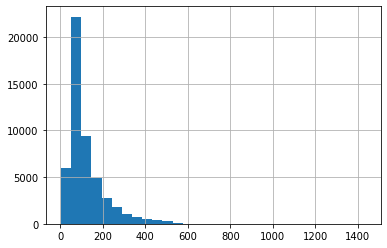

In [8]:
df.tokenized_text_len.hist(bins= 30)
plt.show()

## 2. Unsupervised Approach


In [9]:
%%time
def w2v_trainer(doc_tokens: [str],
                epochs: int = 5,
                workers: int = 3,
                embedding_size: int = 1000,
                window: int = 5, min_count: int = 2):

    w2v_model = Word2Vec(doc_tokens,
                         epochs=epochs,
                         workers=workers,
                         vector_size=embedding_size,
                         window=window,
                         min_count=min_count)
    
    # create objects to store keyed vectors and keyed vocabs
    keyed_vectors = w2v_model.wv
    keyed_vocab = keyed_vectors.key_to_index
    
    return keyed_vectors, keyed_vocab


embedding_size= 1000
# Training a Word2Vec model
keyed_vectors, keyed_vocab = w2v_trainer(df_train['tokenized_text'],
                                               epochs=10, workers=3,
                                               embedding_size=embedding_size,
                                               window=10, min_count=2)

CPU times: user 8min 17s, sys: 1.82 s, total: 8min 19s
Wall time: 4min 27s


## Defining the negative and positive sets
There is no unique formula to choose the positive and negative set [word cloud]. However, in order to have a starting point, I checked the most similar words to the words 'good' and 'bad' in our newly trained embedding space. Mixing it with my judgement on the context, I came up with the following lists:

- `positive_concepts` = ['excellent', 'awesome', 'cool', 'decent', 'amazing', 'strong', 'good', 'great', 'funny', 'entertaining'] 
- `negative_concepts` = ['terrible', 'awful', 'horrible', 'boring', 'bad', 'disappointing', 'weak', 'poor',  'senseless', 'confusing']

Please note that we should make sure that all `positive_concepts` and `negative_concepts` are represented in our word2vec model. 

In [10]:
# Find the most similar words to "good" based on word vectors from our trained model
print('Positive')
keyed_vectors.most_similar('good',topn=15)

Positive


[('decent', 0.5940451622009277),
 ('great', 0.48362821340560913),
 ('nice', 0.4779336750507355),
 ('bad', 0.45992311835289),
 ('alright', 0.45832541584968567),
 ('solid', 0.4581753611564636),
 ('okay', 0.4580387771129608),
 ('fine', 0.45254117250442505),
 ('liked', 0.44730743765830994),
 ('ok', 0.4382731318473816),
 ('excellent', 0.43410593271255493),
 ('cool', 0.415096640586853),
 ('terrific', 0.4146568477153778),
 ('acceptable', 0.41220009326934814),
 ('awesome', 0.4012167453765869)]

In [11]:
# Find the most similar words to "bad" based on word vectors from our trained model
keyed_vectors.most_similar('bad',topn=15)

[('terrible', 0.6057188510894775),
 ('horrible', 0.6045576333999634),
 ('awful', 0.5579134225845337),
 ('atrocious', 0.5546827912330627),
 ('lousy', 0.5212897062301636),
 ('sucks', 0.5200861096382141),
 ('cheesy', 0.5194084048271179),
 ('suck', 0.5059002041816711),
 ('horrid', 0.5028241872787476),
 ('crappy', 0.5011688470840454),
 ('laughable', 0.4745619297027588),
 ('poor', 0.4674936532974243),
 ('good', 0.45992305874824524),
 ('dreadful', 0.4599118232727051),
 ('sucked', 0.44863948225975037)]

In [12]:
# To make sure that all `positive_concepts` are in the keyed word2vec vocabulary
positive_concepts = ['excellent', 'awesome', 'cool','decent','amazing', 'strong', 'good', 'great', 'funny', 'entertaining'] 
pos_concepts = [concept for concept in positive_concepts if concept in keyed_vocab]
len(positive_concepts)

10

In [13]:
# To make sure that all `negative_concepts` are in the keyed word2vec vocabulary 
negative_concepts = ['terrible','awful','horrible','boring','bad', 'disappointing', 'weak', 'poor',  'senseless','confusing'] 
neg_concepts = [concept for concept in negative_concepts if concept in keyed_vocab]
len(negative_concepts)

10

In [14]:
def calculate_overall_similarity_score(keyed_vectors,
                             target_tokens, doc_tokens):
    
    target_tokens = [token for token in target_tokens if token in keyed_vectors]
    doc_tokens = [token for token in doc_tokens if token in keyed_vectors]
    similarity_score = keyed_vectors.n_similarity(target_tokens, doc_tokens)
    return similarity_score


def overall_semantic_sentiment_analysis (keyed_vectors,
                                         positive_target_tokens, negative_target_tokens,
                                         doc_tokens, doc_is_series: bool = True):
    
    positive_score = doc_tokens.apply(lambda x: calculate_overall_similarity_score(keyed_vectors=keyed_vectors, 
                                                                 target_tokens=positive_target_tokens, 
                                                                 doc_tokens=x))
    negative_score = doc_tokens.apply(lambda x: calculate_overall_similarity_score(keyed_vectors=keyed_vectors, 
                                                                 target_tokens=negative_target_tokens, 
                                                                 doc_tokens=x))
    semantic_sentiment_score = positive_score - negative_score              
    return semantic_sentiment_score

In [15]:
%%time
# Calculating Semantic Sentiment Scores by OSSA model
overall_df_scores = overall_semantic_sentiment_analysis(keyed_vectors = keyed_vectors,
                                                   positive_target_tokens = pos_concepts, 
                                                   negative_target_tokens = neg_concepts,
                                                   doc_tokens = df_test['tokenized_text'])

def to_categorical(overall_df_scores):
    pred=[]
    for ele in overall_df_scores:
        if ele <0:
            pred.append(0)
        else:
            pred.append(1)
    return pred

CPU times: user 10.4 s, sys: 15.1 ms, total: 10.4 s
Wall time: 10.5 s


In [16]:
df_test['pred']= to_categorical(overall_df_scores)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


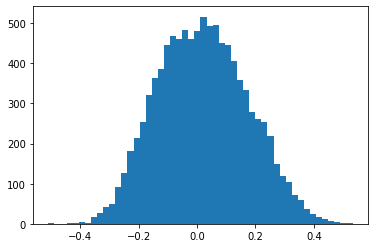

In [17]:
plt.hist(overall_df_scores, bins=50)
plt.show()

In [18]:
def evaluate_model (y_true: pd.Series, 
                              y_pred: pd.Series, 
                              report:bool = False,
                              plot: bool = False)-> float:
    """
    A function to calculate F1, Accuracy, Recall, and Precision Score
    If report: it prints classification_report 
    If plot: it prints Confusion Matrix Heatmap
    """
    if report:
        print(classification_report(y_true, 
                            y_pred,
                            digits=4))
    if plot:
        # figure
        fig, ax = plt.subplots(figsize=(4, 4))
        conf_matrix = pd.crosstab(y_true, 
                           y_pred, 
                           rownames=['Actual'], 
                           colnames=['Predicted'])
        sns.heatmap(conf_matrix, 
                    annot=True, fmt=".0f",
                    cmap='RdYlGn', # use orange/red colour map
                    cbar_kws={'fraction' : 0.04}, # shrink colour bar
                    linewidth=0.3, # space between cells
                   ) 
        plt.title('Confusion Matrix', fontsize=14)
        plt.show()

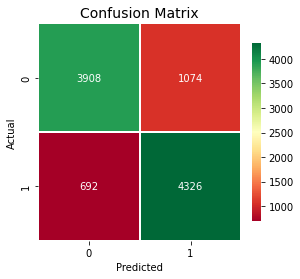

In [19]:
evaluate_model(df_test['sentiment'],
               df_test['pred'], False, True)

In [20]:
evaluate_model(df_test['sentiment'],
               df_test['pred'], True, False)

              precision    recall  f1-score   support

           0     0.8496    0.7844    0.8157      4982
           1     0.8011    0.8621    0.8305      5018

    accuracy                         0.8234     10000
   macro avg     0.8253    0.8233    0.8231     10000
weighted avg     0.8253    0.8234    0.8231     10000

